## Import all required libraries

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline

<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

In [3]:
# REGIONAL CO2 STORAGE POTENTIAL
# read storage potential in GtCO2
potentials = pd.read_excel("storage_by_country.xlsx").set_index("ISO")

# read regional country lists
reg_list_path = "region_code_list.yaml"

with open(reg_list_path, 'r') as file:
    reg_data = yaml.safe_load(file)

# creating R12 potentials dataframe
R12_potential = pd.DataFrame(columns=["Potential"])

for reg in set(reg_data.keys()) - {"World"}:
    val = potentials.loc[reg_data[reg]["child"]]["Potential"].sum()
    R12_potential.loc[reg] = np.round(1000*val/3.667, 3) # convert to MtCO2
    
R12_pot = R12_potential.div(90).mul(0.5) # for SSP2

In [4]:
R12_potential

,Potential
R12_RCPA,3754.285
R12_MEA,57369.171
R12_WEU,11793.358
R12_CHN,15712.475
R12_FSU,83310.661
R12_NAM,58983.981
R12_AFR,61399.222
R12_EEU,1808.370
R12_PAO,34233.825
R12_PAS,21108.578


In [5]:
# SSPs and scenarios lists
ssps = ["LED","SSP1","SSP2","SSP3","SSP4","SSP5"]
ssps = ["SSP2"]

max_rate = np.round(15000/3.667,0) * 10 # convert MtCO2/y to MtC/y >>>>>>>>>> remove * 10



## Create baseline and emission bound scenarios with split CO2 infrastructure

-------- SSP2 runs --------
DAC 1000f|Split CO2 infrastructure


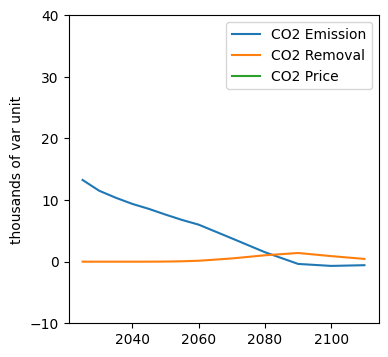

In [6]:
modes = ["M1","M2","M3"]
len_periods = {2025:5, 2030:5, 2035:5, 2040:5, 
               2045:5, 2050:5, 2055:5, 2060:5, 
               2070:10, 2080:10, 2090:10, 2100:10, 2110:10}

for ssp in ssps:
    print(f"-------- {ssp} runs --------")
    # CONNECT TO DATABASE
    mp = ixmp.Platform()

    # calling baseline scenario
    base_scen = message_ix.Scenario(mp, model=f'SSP_dev_{ssp}_v0.1_dac', scenario="baseline_v0.14")
    
    year_df = base_scen.vintage_and_active_years()
    vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
    model_horizon = base_scen.set("year")
    
    nodes = [node for node in base_scen.set("node") if node != "World"]
    years = [year for year in base_scen.set("year") if year > 2025]
    
    # Create DAC baseline scenario with split CO2 T&D infrastructure
    scen = base_scen.clone(
        f"SSP_dev_{ssp}_v0.1_dac-co2split",
        "1000f_v0.14",
        "dac baseline with split CO2 T&D",
        keep_solution=False, 
    )
    scen.check_out()

    ## remove old setup
    ### remove relations
    params = ['relation_activity']

    techs = ['co2_tr_dis', 'bco2_tr_dis',
             'bio_istig_ccs','bio_ppl_co2scr','eth_bio_ccs','h2_bio_ccs','liq_bio_ccs',
             'c_ppl_co2scr','cement_co2scr','coal_adv_ccs','g_ppl_co2scr','gas_cc_ccs',
             'h2_coal_ccs','h2_smr_ccs','igcc_ccs','meth_coal_ccs','meth_ng_ccs','syn_liq_ccs']
    
    rels = ['co2_trans_disp','bco2_trans_disp','CO2_Emission_Global_Total', 'CO2_Emission',]

    for par in params:
        scen.remove_par(par, scen.par(par,{'technology':techs,'relation':rels}))

    ## remove pipelines
    ### list of parameters to remove
    params = ['inv_cost','fix_cost','input','capacity_factor','technical_lifetime',
              'construction_time','abs_cost_activity_soft_up','growth_activity_lo',
              'level_cost_activity_soft_lo','level_cost_activity_soft_up','relation_activity',
              'var_cost','output','emission_factor','soft_activity_lo','soft_activity_up',
              'growth_activity_up','initial_activity_up']

    pipes = ['co2_tr_dis', 'bco2_tr_dis']
    
    for par in params:
        scen.remove_par(par, scen.par(par,{'technology':pipes}))

    ## remove sets    
    scen.remove_set('technology',pipes)
    scen.remove_set('relation',rels[0:2])
    
    # add new setup
    ## add CO2_storage
    scen.add_set('emission',"CO2_storage")

    ## setup pipelines and storage technologies
    filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/data_v2test/co2infrastructure_data_ssp2dev.yaml'
    add_tech(scen,filepath=filepath)
    
    ## removing some pipelines and storage parameters
    newpipesnstors = ['co2_tr_sd1', 'co2_tr_sd2', 'co2_tr_sd3', 'co2_tr_sd4','co2_tr_sd5', 'co2_tr_sd6','co2_stor']
    pars2remove = ['var_cost','input','output','emission_factor','capacity_factor']
    for par in pars2remove:
        df = scen.par(par,{'technology':newpipesnstors})
        df= df.loc[df['year_vtg'] != df['year_act']]
        scen.remove_par(par, df)

    ## removing excess year_act
    pars2remove = ['output']
    for par in pars2remove:
        df = scen.par(par,{'technology':techs})
        df = df.loc[df['year_act'] > df['year_vtg'].add(50)]
        scen.remove_par(par, df)
    
    ## setup dac technologies
    filepath = f'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/SSPs/ssp_data/data_v2test/daccs_setup_data_ssp2dev.yaml'
    add_tech(scen,filepath=filepath)
    
    ## removing some dac parameters
    newpipesnstors = ['co2_tr_sd1', 'co2_tr_sd2', 'co2_tr_sd3', 'co2_tr_sd4','co2_tr_sd5', 'co2_tr_sd6','co2_stor']
    pars2remove = ['emission_factor','capacity_factor','var_cost','input','output']
    for par in pars2remove:
        df = scen.par(par,{'technology':newpipesnstors})
        df= df.loc[df['year_vtg'] != df['year_act']]
        scen.remove_par(par, df)

    ## removing excess year_act
    pars2remove = ['capacity_factor','fix_cost','input','output']
    techs = ['dac_lt', 'dac_ht']
    for par in pars2remove:
        df = scen.par(par,{'technology':techs})
        df = df.loc[df['year_act'] > df['year_vtg'].add(30)]
        scen.remove_par(par, df)

    # SETUP TECHNOLOGY AND RELATIONS TO TRACK CUMULATIVE STORAGE
    ## adding set and dummy technologies
    scen.add_set("technology","co2_storcumulative")
    for mode in modes:
        scen.add_set("relation",f"co2_storcum_{mode}")


    ## create relation activity
    list_relation = []
    for node in nodes:
        for mode in modes:
            for yr in years:
                ya = [y for y in years if y <= yr]
                relact_co2stor = make_df("relation_activity",
                            relation=f"co2_storcum_{mode}",
                            node_rel=node,
                            year_rel=yr,
                            node_loc=node,
                            technology="co2_stor",
                            year_act=ya,
                            mode=mode,
                            #value= [-len_periods[y] for y in ya],
                            value= [-len_periods[y] if y != yr else -60 for y in ya],
                            unit = "-"
                       )

                relact_co2storcumulative = make_df("relation_activity",
                            relation=f"co2_storcum_{mode}",
                            node_rel=node,
                            year_rel=yr,
                            node_loc=node,
                            technology="co2_storcumulative",
                            year_act=yr,
                            mode=mode,
                            value=1,
                            unit = "-"
                       )
                list_relation += [relact_co2stor, relact_co2storcumulative]
    df_relation = pd.concat(list_relation)
    
    ## create relation bounds
    list_rel_eq = []
    for node in nodes:
        for mode in modes:
            rel_eq = make_df("relation_upper",
                    relation = f"co2_storcum_{mode}",
                    node_rel = node,
                    year_rel = years,
                    value = 0,
                    unit = "-"
                   )
            list_rel_eq += [rel_eq]
    df_rel_eq = pd.concat(list_rel_eq)

    ## adding parameters
    scen.add_par("relation_activity", df_relation)
    scen.add_par("relation_upper", df_rel_eq)
    scen.add_par("relation_lower", df_rel_eq)
    
    
    ## adding set up for limiting CO2 storage availabilities
    nodes = [node for node in nodes if node not in ["R12_GLB","World"]]
    df_list = []
    for node in nodes:
        for year in years:
            df = make_df("bound_activity_up",
                         node_loc=node,
                         technology="co2_storcumulative",
                         year_act=year,
                         mode="all",
                         time="year",
                         value = R12_pot.loc[node,"Potential"]*90,
                         unit = "???",
                        )
            df_list += [df]
    df_stor = pd.concat(df_list)
    
    scen.add_par("bound_activity_up", df_stor)

    # SETUP TECHNOLOGY AND RELATIONS TO LIMIT GLOBAL INJECTION RATES
    ## adding set and dummy technologies
    scen.add_set("technology","co2_stor_glb")
    for mode in modes:
        scen.add_set("relation",f"co2_storglobal_{mode}")


    ## create relation activity
    list_relation = []
    for mode in modes:
        for yr in years:
            for node in nodes:
                relact_co2stor = make_df("relation_activity",
                            relation=f"co2_storglobal_{mode}",
                            node_rel="R12_GLB",
                            year_rel=yr,
                            node_loc=node,
                            technology="co2_stor",
                            year_act=yr,
                            mode=mode,
                            value= -1,
                            unit = "-"
                       )
                list_relation += [relact_co2stor]
            relact_co2stor_glb = make_df("relation_activity",
                        relation=f"co2_storglobal_{mode}",
                        node_rel="R12_GLB",
                        year_rel=yr,
                        node_loc="R12_GLB",
                        technology="co2_stor_glb",
                        year_act=yr,
                        mode=mode,
                        value=1,
                        unit = "-"
                   )
            list_relation += [relact_co2stor_glb]
    df_relation = pd.concat(list_relation)

    ## create relation bounds
    list_rel_eq = []
    for mode in modes:
        rel_eq = make_df("relation_upper",
                relation = f"co2_storglobal_{mode}",
                node_rel = "R12_GLB",
                year_rel = years,
                value = 0,
                unit = "-"
               )
        list_rel_eq += [rel_eq]
    df_rel_eq = pd.concat(list_rel_eq)

    ## adding parameters
    scen.add_par("relation_activity", df_relation)
    scen.add_par("relation_upper", df_rel_eq)
    scen.add_par("relation_lower", df_rel_eq)
    
    df_list = []
    for year in years:
        df = make_df("bound_activity_up",
                     node_loc="R12_GLB",
                     technology="co2_stor_glb",
                     year_act=year,
                     mode="all",
                     time="year",
                     value = max_rate,
                     unit = "???",
                    )
        df_list += [df]
    df_co2ratelim = pd.concat(df_list)
    
    ## adding parameters
    scen.add_par("bound_activity_up", df_co2ratelim)
    
    ## adding relation_upper and _lower for market penetration limit
    rels = ["DAC_mpen_c"]
    df_list = []
    for rel in rels:
        for node in nodes:
            df = make_df("relation_upper",
                         relation=rel,
                         node_rel=node,
                         year_rel=list(sorted(set(act_years))),
                         unit = "-",
                         value = 0
                        )
            df_list = df_list + [df]
    dfpar2add = pd.concat(df_list)
    scen.add_par("relation_upper", dfpar2add)
    scen.add_par("relation_lower", dfpar2add)
    
    
    ## add emission bound
    scen.add_par('bound_emission', ['World', 'TCE', 'all', 'cumulative'], value=4046, unit="tC")
    
    
    scen.commit(comment=f"{ssp} baseline scenario with dac and split CO2 infrastructure")
    scen.set_as_default()
    
    scen.solve(solve_options={'scaind':'1'})
    
    print("DAC 1000f|Split CO2 infrastructure")
    plotvars(scen)
    

# CLOSE CONNECTION
mp.close_db()

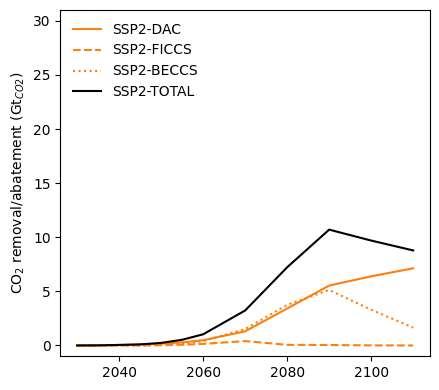

In [7]:
colors = {"SSP1":"tab:red","SSP2":"tab:orange","SSP3":"tab:green","SSP4":"tab:blue","SSP5":"tab:purple",}
lines = ["-","--","-.",":",(0, (3, 1, 1, 1, 1, 1))]
ssps = ["SSP2"]

dactec = ['dac_lt','dac_ht']


mp = ixmp.Platform()

plt.figure(figsize=(4.5,4))



dacrem = {f"SSP_dev_{ssp}_v0.1_dac-co2split": 
         {f"1000f_v0.14": []} 
         for ssp in ssps}
          
ccsrem = {f"SSP_dev_{ssp}_v0.1_dac-co2split": 
         {f"1000f_v0.14": []} 
         for ssp in ssps}

beccsrem = {f"SSP_dev_{ssp}_v0.1_dac-co2split": 
         {f"1000f_v0.14": []} 
         for ssp in ssps}

totalrem = {f"SSP_dev_{ssp}_v0.1_dac-co2split": 
         {f"1000f_v0.14": []} 
         for ssp in ssps}

        

pipes = ['co2_trans1','co2_trans2','co2_trans3','co2_trans4','co2_trans5','co2_trans6']

for k,v in dacrem.items():
    for k1,v1 in v.items():
        scen = message_ix.Scenario(mp, model=k, scenario=k1)
        dacremoval = (scen.var("ACT",{"technology":pipes,"mode":"M3"})
                   .set_index(["node_loc","technology","year_vtg","year_act","mode","time"])
                   .droplevel(["mode","time"])).mul(3.667).div(1000)
        dacremoval = dacremoval.groupby("year_act").sum()["lvl"]
        dacrem[k][k1] = dacremoval
        
        ccsremoval = (scen.var("ACT",{"technology":pipes,"mode":"M1"})
                   .set_index(["node_loc","technology","year_vtg","year_act","mode","time"])
                   .droplevel(["mode","time"])).mul(3.667).div(1000)
        ccsremoval = ccsremoval.groupby("year_act").sum()["lvl"]
        ccsrem[k][k1] = ccsremoval
        
        beccsremoval = (scen.var("ACT",{"technology":pipes,"mode":"M2"})
                   .set_index(["node_loc","technology","year_vtg","year_act","mode","time"])
                   .droplevel(["mode","time"])).mul(3.667).div(1000)
        beccsremoval = beccsremoval.groupby("year_act").sum()["lvl"]
        beccsrem[k][k1] = beccsremoval
        
        totalremoval = (scen.var("ACT",{"technology":pipes,"mode":["M1","M2","M3"]})
                   .set_index(["node_loc","technology","year_vtg","year_act","mode","time"])
                   .droplevel(["mode","time"])).mul(3.667).div(1000)
        totalremoval = totalremoval.groupby("year_act").sum()["lvl"]
        totalrem[k][k1] = totalremoval


techs_lines = {"DAC":"-","FICCS":"--","BECCS":":","TOTAL":"-"}
for ssp in ssps:
    model = f"SSP_dev_{ssp}_v0.1_dac-co2split"
    scenario = f"1000f_v0.14"
    for tech in techs_lines.keys():
        if tech == "DAC":
            val = dacrem[model][scenario]
        elif tech == "FICCS":
            val = ccsrem[model][scenario]
        elif tech == "BECCS":
            val = beccsrem[model][scenario]
        else:
            val = totalrem[model][scenario]
            
        if tech != "TOTAL":
            kwargs = {"label": f"{ssp}-{tech}","ls":techs_lines[tech],"c":colors[ssp], }
        else:
            kwargs = {"label": f"{ssp}-{tech}","ls":techs_lines[tech],"c":"black", }
        
        plt.plot(val, **kwargs)
    

#plt.xlim(2030,2100)
#plt.xticks(range(2030,2110,10))
plt.ylim(-1,31)
plt.yticks(range(0,35,5))
plt.ylabel("CO$_2$ removal/abatement (Gt$_{CO2}$)")
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.savefig("DAC Cost curve based constraint.jpeg",dpi=300)
plt.show()

mp.close_db()